# Support Vector Machine vs Vanilla Linear Classifier


## Load Important Libraries and Digit Dataset


In [1]:
!pip3 install torch torchvision torchaudio

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, svm, metrics, model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [4]:
digits = datasets.load_digits()

/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/datasets/base.py:550: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  target = data[:, -1].astype(np.int)


In [5]:
target = digits.target
flatten_digits = digits.images.reshape((len(digits.images), -1))

## Visualize Some Handwritten Images in the Dataset


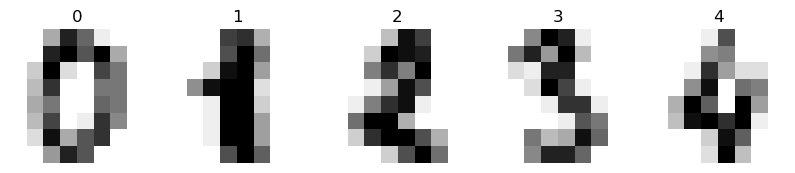

In [6]:
_, axes = plt.subplots(nrows=1, ncols=5, figsize=(10, 4))
for ax, image, label in zip(axes, digits.images, target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title("%i" % label)

## Divide Images into Training and Test Set


I have set the test size to 20% of the total dataset


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    flatten_digits, target, test_size=0.2
)

## Hand-written classification with Logistic Regression


Standardize the dataset to put all the features of the variables on the same scale


In [8]:
scaler = StandardScaler()
X_train_logistic = scaler.fit_transform(X_train)
X_test_logistic = scaler.transform(X_test)

Create the logistic regression and fit the logistic regression and use the <code>l1</code> penalty. Note here that since this is a multiclass problem the Logistic Regression parameter `multi_class` is set to `multinomial`.


In [9]:
logit = LogisticRegression(
    C=0.01, penalty="l1", solver="saga", tol=0.1, multi_class="multinomial"
)

In [10]:
logit.fit(X_train_logistic, y_train)

/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/utils/fixes.py:357: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if _joblib.__version__ >= LooseVersion('0.12'):


LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l1', random_state=None, solver='saga',
          tol=0.1, verbose=0, warm_start=False)

In [11]:
y_pred_logistic = logit.predict(X_test_logistic)

Get the accuracy of the logistic regression


In [12]:
print("Accuracy: " + str(logit.score(X_test_logistic, y_test)))

Accuracy: 0.8083333333333333


Lets plot out the confusion matrix, each row of the matrix represents the instances in a predicted class, while each column represents the instances in an actual class.


In [13]:
label_names = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
cmx = confusion_matrix(y_test, y_pred_logistic, labels=label_names)

Accuracy is fine and above 80% but we can see some heavily misclassified values, The classifier had a hard time classifying <code>8</code>


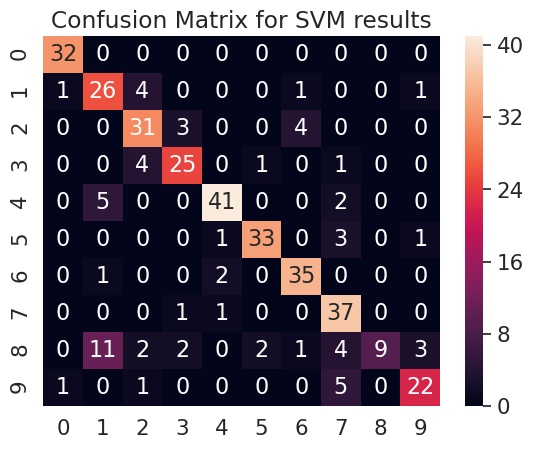

In [14]:
df_cm = pd.DataFrame(cmx)
# plt.figure(figsize=(10,7))
sns.set(font_scale=1.4)  # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16})  # font size
title = "Confusion Matrix for SVM results"
plt.title(title)
plt.show()

## Hand-Written Classification with SVM


Create and fit the SVM model


In [15]:
svm_classifier = svm.SVC(gamma="scale")

In [16]:
svm_classifier.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Predict for our test set


In [17]:
y_pred_svm = svm_classifier.predict(X_test)

Get accuracy for the SVM model, we can see we have a nearly perfect model


In [18]:
print("Accuracy: " + str(accuracy_score(y_test, y_pred_svm)))

Accuracy: 0.9888888888888889


Let's take a look at the confusion matrix for SVM, we can see a nearly perfect model with SVM


In [19]:
label_names = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
cmx = confusion_matrix(y_test, y_pred_svm, labels=label_names)

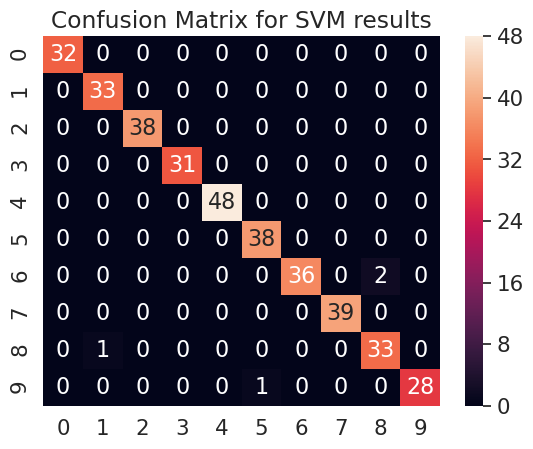

In [20]:
df_cm = pd.DataFrame(cmx)
# plt.figure(figsize=(10,7))
sns.set(font_scale=1.4)  # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16})  # font size
title = "Confusion Matrix for SVM results"
plt.title(title)
plt.show()

## Comparing both SVM and Logistic Regression with K-Fold Cross Validation

k-fold Cross validation is used when there are limited samples, the handwritten dataset contains about 1800 samples, this will give an opportunity for all the data to be in the training and test set at different given times. We will add <code>l2</code> regularization to visualize how well they both do against SVM.


In [21]:
algorithm = []
algorithm.append(("SVM", svm_classifier))
algorithm.append(("Logistic_L1", logit))
algorithm.append(
    (
        "Logistic_L2",
        LogisticRegression(
            C=0.01, penalty="l2", solver="saga", tol=0.1, multi_class="multinomial"
        ),
    )
)


results = []
names = []
y = digits.target
for name, algo in algorithm:
    k_fold = model_selection.KFold(n_splits=10, random_state=10)
    if name == "SVM":
        X = flatten_digits
        cv_results = model_selection.cross_val_score(
            algo, X, y, cv=k_fold, scoring="accuracy"
        )
    else:
        scaler = StandardScaler()
        X = scaler.fit_transform(flatten_digits)
        cv_results = model_selection.cross_val_score(
            algo, X, y, cv=k_fold, scoring="accuracy"
        )

    results.append(cv_results)
    names.append(name)

/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/model_selection/_split.py:437: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/model_selection/_split.py:113: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.

We plot and we can see that SVM performs better all the time even with k-fold cross validation and it is better than both Logistic regressions on average


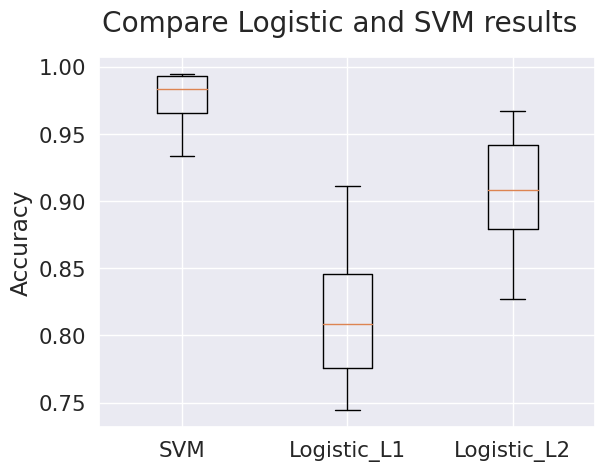

In [22]:
fig = plt.figure()
fig.suptitle("Compare Logistic and SVM results")
ax = fig.add_subplot()
plt.boxplot(results)
plt.ylabel("Accuracy")
ax.set_xticklabels(names)
plt.show()